# Descarga y EDA

In [192]:
import gzip
import json
import pandas as pd
import matplotlib.pyplot as plt
import random
from collections import Counter
from urllib.request import urlretrieve
import os
import shutil
import wget
import itertools
import nltk
import numpy as np

# Descarga de Datos

Iniciamos nuestro análisis con la descarga del conjunto de datos que exploraremos.El EDA nos ayudará a comprender las características fundamentales del conjunto de datos, como su estructura, distribución y posibles anomalías

In [193]:
# Creo carpeta Corpus
! mkdir Corpus

mkdir: cannot create directory ‘Corpus’: File exists


In [194]:
wget.download("http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Sports_and_Outdoors_5.json.gz")



'reviews_Sports_and_Outdoors_5.json.gz'

In [195]:
# Descomprimir y mover archivos
if descargar_corpus_and_rating:
    with gzip.open("reviews_Sports_and_Outdoors_5.json.gz", 'rb') as infile:
        with open("./Corpus/reviews_Sports_and_Outdoors_5.json", 'wb') as outfile:  # Asegúrate de añadir .json aquí
            for line in infile:
                outfile.write(line)



In [184]:
# Borra los archivos gz
if descargar_corpus_and_rating:
    os.remove("reviews_Sports_and_Outdoors_5.json.gz")

In [185]:
# Función para importar el dataset (mediante generador)
def get_json_data(file):
    for line in open(file, 'r'):
        yield json.loads(line.strip())

In [186]:
corpus_path = "./Corpus/"
file1 = corpus_path + "reviews_Sports_and_Outdoors_5.json"
n_samples = 3000

In [187]:
df = pd.DataFrame(itertools.islice(get_json_data(file1), n_samples))
df.head()


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,AIXZKN4ACSKI,1881509818,David Briner,"[0, 0]",This came in on time and I am veru happy with ...,5.0,Woks very good,1390694400,"01 26, 2014"
1,A1L5P841VIO02V,1881509818,Jason A. Kramer,"[1, 1]",I had a factory Glock tool that I was using fo...,5.0,Works as well as the factory tool,1328140800,"02 2, 2012"
2,AB2W04NI4OEAD,1881509818,J. Fernald,"[2, 2]",If you don't have a 3/32 punch or would like t...,4.0,"It's a punch, that's all.",1330387200,"02 28, 2012"
3,A148SVSWKTJKU6,1881509818,"Jusitn A. Watts ""Maverick9614""","[0, 0]",This works no better than any 3/32 punch you w...,4.0,It's a punch with a Glock logo.,1328400000,"02 5, 2012"
4,AAAWJ6LW9WMOO,1881509818,Material Man,"[0, 0]",I purchased this thinking maybe I need a speci...,4.0,"Ok,tool does what a regular punch does.",1366675200,"04 23, 2013"


In [188]:
# Comprobamos nuestros datos
print("df.shape: {}\n".format(df.shape))
print(df.dtypes)

df.shape: (3000, 9)

reviewerID         object
asin               object
reviewerName       object
helpful            object
reviewText         object
overall           float64
summary            object
unixReviewTime      int64
reviewTime         object
dtype: object


**Eliminación de Columnas No Relevantes**


Para centrarnos en el análisis de texto y la calificación de las reseñas, eliminamos columnas que no aportan a nuestro objetivo de análisis. Estas columnas incluyen información del revisor y metadatos de la reseña que, aunque pueden ser útiles para otros análisis, no son necesarios para nuestro enfoque actual en el texto de la reseña "reviewText" y la calificación "overall".

In [189]:
# Nos deshacemos de columnas que no son de interés
cols_to_drop = ["reviewerID", "asin", "reviewerName", "helpful", "unixReviewTime", "reviewTime", "summary"]
df.drop(columns=cols_to_drop, inplace=True)

In [190]:
# Comprobamos nuestros datos
df.head()

,reviewText,overall
0,This came in on time and I am veru happy with ...,5.0
1,I had a factory Glock tool that I was using fo...,5.0
2,If you don't have a 3/32 punch or would like t...,4.0
3,This works no better than any 3/32 punch you w...,4.0
4,I purchased this thinking maybe I need a speci...,4.0


# Exploración

Realizamos una exploración inicial del texto para obtener una comprensión básica de su estructura. Contamos el número total de palabras y frases en nuestro conjunto de datos.

 Para contar palabras, dividimos el texto en tokens basados en espacios, resultando en un total de 7,483 palabras.

In [127]:
# Palabras (División por espacios)
tokens = (token for sentence in df[["reviewText"]].values for token in sentence[0].split())
print("Palabras: {}\n".format(len(list(tokens))))

Palabras: 269627



Para las frases, usamos el punto como delimitador, identificando 608 frases. Este paso nos da una idea de la longitud y complejidad del texto que estamos analizando.

In [128]:
# Frases (División por punto)
sentences = (token for sentence in df[["reviewText"]].values for token in sentence[0].split('.'))
print("Frases: {}\n".format(len(list(sentences))))

Frases: 22028



# Procesado de los datos

###***Tokenizar***

La tokenización es el proceso de dividir el texto en unidades más pequeñas, como palabras o frases. Realizamos dos niveles de tokenización: por oraciones y por palabras. La tokenización por oraciones nos ayuda a entender cómo está compuesto el texto en términos de oraciones completas, como se muestra en el primer resultado.

In [129]:
# Librerías necesarias
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [130]:
# función
def tokenizer_sentence_level(reviews, tonkenizer=nltk.tokenize.sent_tokenize):
    for review in reviews:
        yield tonkenizer(review[0])

In [131]:
# Procesado
reviews_sentences = tokenizer_sentence_level(df[["reviewText"]].values)
print(next(
    tokenizer_sentence_level(df[["reviewText"]].values)
))

['This came in on time and I am veru happy with it, I haved used it already and it makes taking out the pins in my glock 32 very easy']


In [132]:
from nltk import RegexpTokenizer

# función
def tokenizer_word_level(reviews, tokenizer=nltk.RegexpTokenizer(r'\w+')):
    for review in reviews:
        yield tokenizer.tokenize(review[0])

In [133]:
# Procesado
corpus = tokenizer_word_level(df[["reviewText"]].values)
print(next(corpus))

['This', 'came', 'in', 'on', 'time', 'and', 'I', 'am', 'veru', 'happy', 'with', 'it', 'I', 'haved', 'used', 'it', 'already', 'and', 'it', 'makes', 'taking', 'out', 'the', 'pins', 'in', 'my', 'glock', '32', 'very', 'easy']


##**Normalización a Minúsculas**

Convertimos todas las palabras tokenizadas a minúsculas para homogeneizar el texto, facilitando la comparación y análisis de palabras. Este paso de normalización es crucial para evitar duplicidades basadas en diferencias de mayúsculas y minúsculas.

In [134]:
# función
def corpus_to_lower(reviews):
    for review in reviews:
        yield [word.lower() for word in review]

In [135]:
# Procesado
corpus = tokenizer_word_level(df[["reviewText"]].values)
corpus = corpus_to_lower(corpus)
print(next(corpus))

['this', 'came', 'in', 'on', 'time', 'and', 'i', 'am', 'veru', 'happy', 'with', 'it', 'i', 'haved', 'used', 'it', 'already', 'and', 'it', 'makes', 'taking', 'out', 'the', 'pins', 'in', 'my', 'glock', '32', 'very', 'easy']


##**Eliminación de Stop Words**

Las stop words son palabras comunes que generalmente no aportan significado relevante al análisis del texto. Eliminando estas palabras, podemos concentrarnos en el contenido que efectivamente contribuye al significado del texto.

In [136]:
# Bajamos las stopwords de nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [137]:
# Elegimos las stopwords en inglés
print(stopwords.words('english')[:10])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


In [138]:
# función
def drop_stopwords(reviews, stopwords=nltk.corpus.stopwords.words('english')):
    for review in reviews:
        yield [word for word in review if word not in stopwords]

In [139]:
# Procesado
corpus = tokenizer_word_level(df[["reviewText"]].values)
corpus = drop_stopwords(corpus)
print(next(corpus))

['This', 'came', 'time', 'I', 'veru', 'happy', 'I', 'haved', 'used', 'already', 'makes', 'taking', 'pins', 'glock', '32', 'easy']


Después de aplicar este filtro, observamos cómo se reduce el tamaño de nuestra colección de tokens, excluyendo palabras como 'i', 'in', 'on', que son típicamente consideradas stop words en inglés.

#**Stemming**

Aplicamos stemming para reducir las palabras a su raíz o base, lo que permite agrupar variantes de una palabra como una sola entidad. Este proceso nos ayuda a simplificar el análisis y a reducir la complejidad del conjunto de datos.

In [140]:
# Librerías necesarias
from nltk.stem.snowball import EnglishStemmer

In [141]:
# Función
def stemming_data(reviews, stemmer=nltk.stem.snowball.EnglishStemmer(ignore_stopwords=True)):
    for review in reviews:
        yield [stemmer.stem(word) for word in review]

In [142]:
# Procesado
corpus = tokenizer_word_level(df[["reviewText"]].values)
corpus = stemming_data(corpus)
print(next(corpus))

['this', 'came', 'in', 'on', 'time', 'and', 'i', 'am', 'veru', 'happi', 'with', 'it', 'i', 'have', 'use', 'it', 'alreadi', 'and', 'it', 'make', 'take', 'out', 'the', 'pin', 'in', 'my', 'glock', '32', 'very', 'easi']


##**Lemmatization**

 A diferencia del stemming, la lematización reduce las palabras a su lema, considerando el contexto y el significado de la palabra. Este proceso es más sofisticado y tiende a producir resultados que están más cerca de las raíces lingüísticas de las palabras.

In [143]:
# Librerías necesarias
nltk.download('omw-1.4')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [144]:
# Función
def lemmatizing_data(reviews, lemmatizer=nltk.stem.WordNetLemmatizer()):
    for review in reviews:
        yield [lemmatizer.lemmatize(word) for word in review]

In [145]:

# Procesado
corpus = tokenizer_word_level(df[["reviewText"]].values)
corpus = lemmatizing_data(corpus)
print(next(corpus))

['This', 'came', 'in', 'on', 'time', 'and', 'I', 'am', 'veru', 'happy', 'with', 'it', 'I', 'haved', 'used', 'it', 'already', 'and', 'it', 'make', 'taking', 'out', 'the', 'pin', 'in', 'my', 'glock', '32', 'very', 'easy']


En el resultado mostrado, sin embargo, las palabras parecen no haber cambiado, lo cual puede indicar que ya están en su forma lematizada o que el lematizador no encontró una forma lema diferente para estas palabras específicas.

#Conteo, bolsa de palabras y N-Gramas

##**Bag of words**

In [146]:

# Librerías necesarias
from collections import Counter
import matplotlib.pyplot as plt

In [147]:

# Definición de funciones (1/2)

# extrae las palabras del corpus
def get_words(corpus):
    return [word for review in corpus for word in review]

# extrae el vocabulario
def get_alphabet(words):
    return set(words)

# frecuencia de cada palabra
def get_frequency(words):
    return Counter(words)

# Las n palabras mas comunes
def get_most_commons(words, n=15):
    return Counter(words).most_common(20)

In [148]:
# Definición de funciones (2/2)

# Plot Bag of Words
def plot_bag_of_words(corpus):

    # extrae las palabras del corpus
    words = get_words(corpus)

    # Las n palabras mas comunes
    wf_most_common = get_most_commons(words, 20)

    # Devuelve la bolsa de palabras ordenada
    bow = zip(*sorted(zip([w[0] for w in wf_most_common],
                          [w[1] for w in wf_most_common]),
                      key=lambda x: x[1]))

    # Plot
    plt.barh(*bow)
    plt.show()

In [149]:
# Nuestro corpus para el BoW
corpus = tokenizer_word_level(df[["reviewText"]].values)
corpus = corpus_to_lower(corpus)
corpus = drop_stopwords(corpus)
corpus = lemmatizing_data(corpus)
corpus = list(cleaning_no_alpha(corpus))

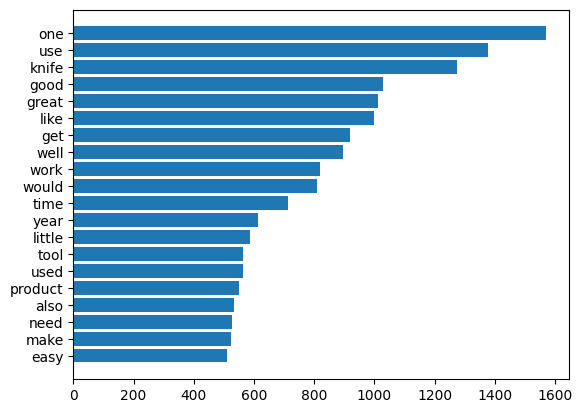

In [150]:
plot_bag_of_words(corpus)


##**N-Grams 2**

In [153]:
# Librerías necesarias
from nltk import ngrams
from nltk.probability import FreqDist

In [154]:
# Creamos una función para simplificar
def get_n_grams(words, n=2):

    # creación de ngramas
    ngrams_ = list(ngrams(words, n))

    # FreqDist para cada ngramas
    ng_freq = FreqDist(ngrams_)

    return ngrams_, ng_freq

# Ploteamos nuestros ngramas mas comunes
def plot_most_commons(words, n_words=2, n_most_common=20):

    _, ng_freq = get_n_grams(words, n_words)

    # Los más comunes
    ng_freq_most_common = ng_freq.most_common(n_most_common)

    # parseamos
    ngs_ = [str(ng[0]) for ng in ng_freq_most_common]

    # Las frecuencias de los más comunes
    ngs_f_ = [ng[1] for ng in ng_freq_most_common]

    # Empaquetamos
    ngs_f_, ngs_ = zip(*sorted(zip(ngs_f_, ngs_)))

    # Ploteamos
    plt.barh(ngs_, ngs_f_)
    plt.title('{}_gram frequencies'.format(n_words))
    plt.show()

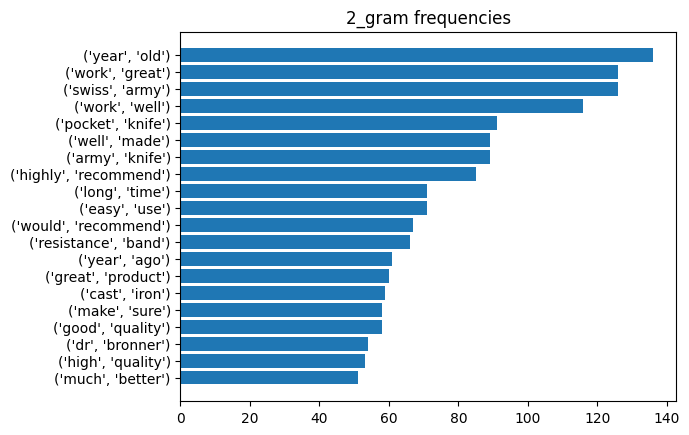

In [155]:
plot_most_commons(get_words(corpus), n_words=2, n_most_common=20)

Algunos de los bi-gramas más frecuentes como "high quality", "would recommend", y "long time" sugieren una percepción general positiva de los productos reseñados, destacando su calidad y la disposición de los usuarios a recomendarlos. Estas frases son útiles para identificar atributos del producto que los usuarios valoran.

##**Nube de palabras**

In [156]:
# Librerías necesarias
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [157]:
# Nube de palabras
def plot_word_cloud(text):
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(' '.join(text))
    plt.figure( figsize=(12,6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

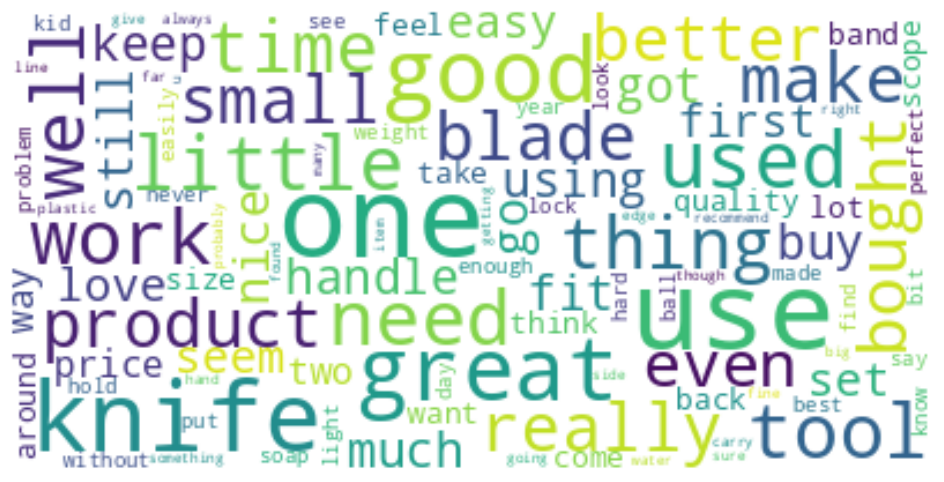

In [158]:
plot_could_words = True
if plot_could_words:
    plot_word_cloud(get_words(corpus))

##**Exploración respecto a sentimiento**

array([[<Axes: title={'center': 'overall'}>]], dtype=object)

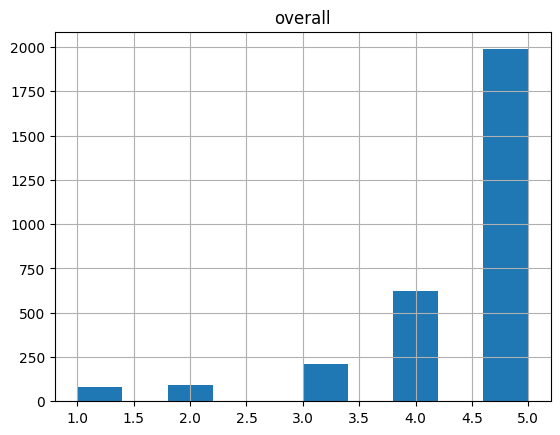

In [159]:
  # Histograma para ver la distribución
df[["overall"]].hist()

Tomaremos 3 estrellas para abajo como comentarios negativos y 4 y 5 como positivos para mejorar la distribución.

In [160]:
# Función
def sentiment(row):
    return 0 if int(row[['overall']]) < 3 else 1

In [161]:
# Creamos nuestra columna de sentimiento
df['sentiment'] = df.apply(lambda row: sentiment(row), axis=1)

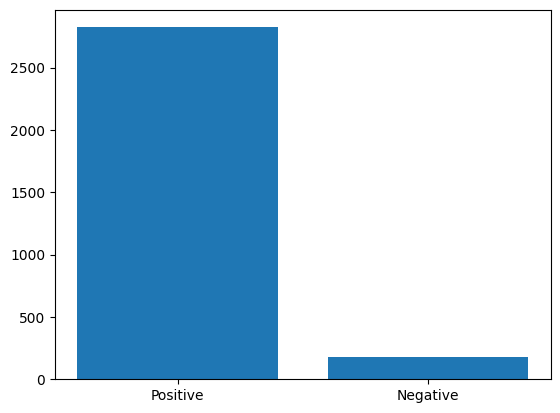

In [162]:
# Mostramos
plt.bar(["Positive", "Negative"],
        [df[df["sentiment"] == 1]["sentiment"].count(),
         df[df["sentiment"] == 0]["sentiment"].count()])
plt.show()

In [163]:
# Corpus positivo
corpus_positive = tokenizer_word_level(df[df["sentiment"] == 1][["reviewText"]].values)
corpus_positive = corpus_to_lower(corpus_positive)
corpus_positive = drop_stopwords(corpus_positive)
corpus_positive = lemmatizing_data(corpus_positive)
corpus_positive = list(cleaning_no_alpha(corpus_positive))

# Corpus negativo
corpus_negative = tokenizer_word_level(df[df["sentiment"] == 0][["reviewText"]].values)
corpus_negative = corpus_to_lower(corpus_negative)
corpus_negative = drop_stopwords(corpus_negative)
corpus_negative = lemmatizing_data(corpus_negative)
corpus_negative = list(cleaning_no_alpha(corpus_negative))

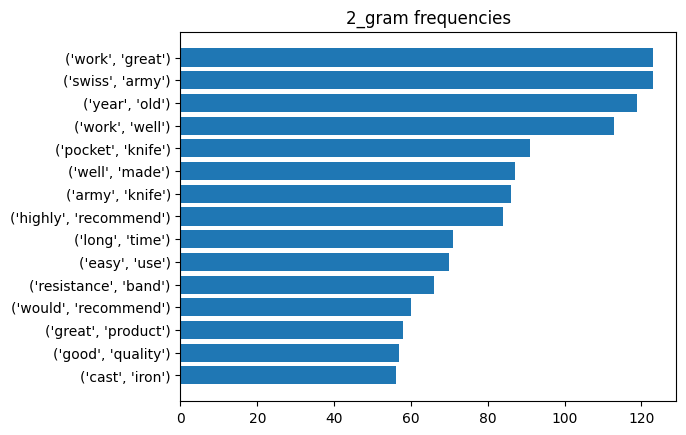

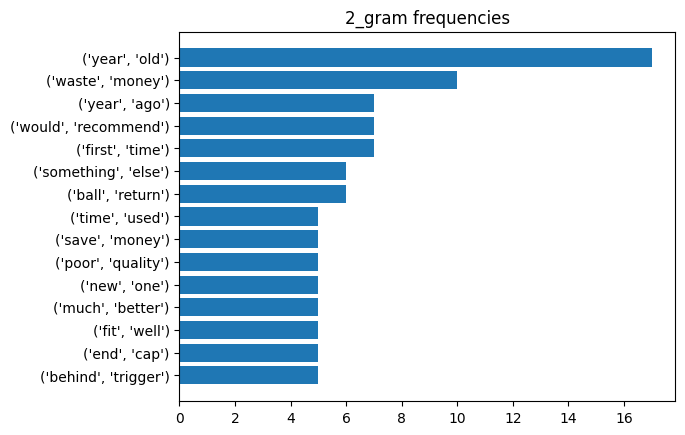

In [164]:
plot_most_commons(get_words(corpus_positive), n_words=2, n_most_common=15)
plot_most_commons(get_words(corpus_negative), n_words=2, n_most_common=15)

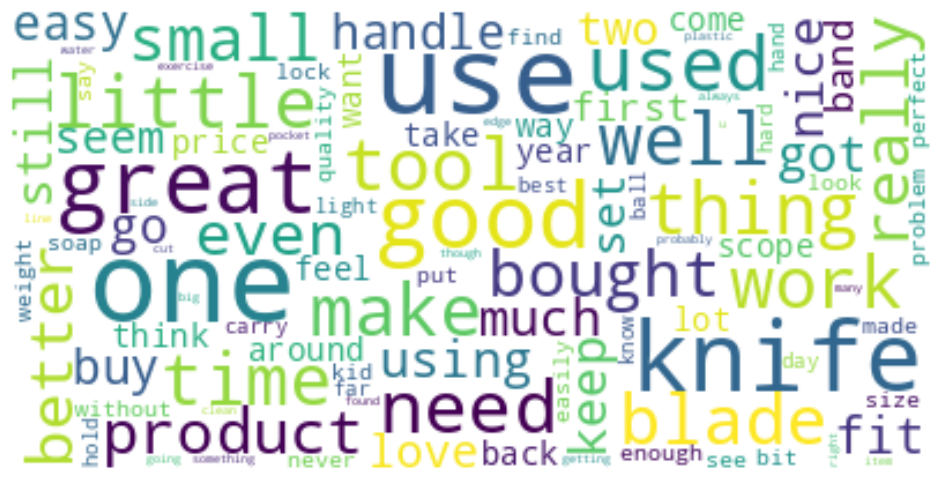

In [165]:
plot_word_cloud(get_words(corpus_positive))


Palabras como "good", "great", "love", y "nice" son destacadas, sugiriendo que las reseñas positivas a menudo mencionan la calidad satisfactoria del producto y la experiencia general del usuario.

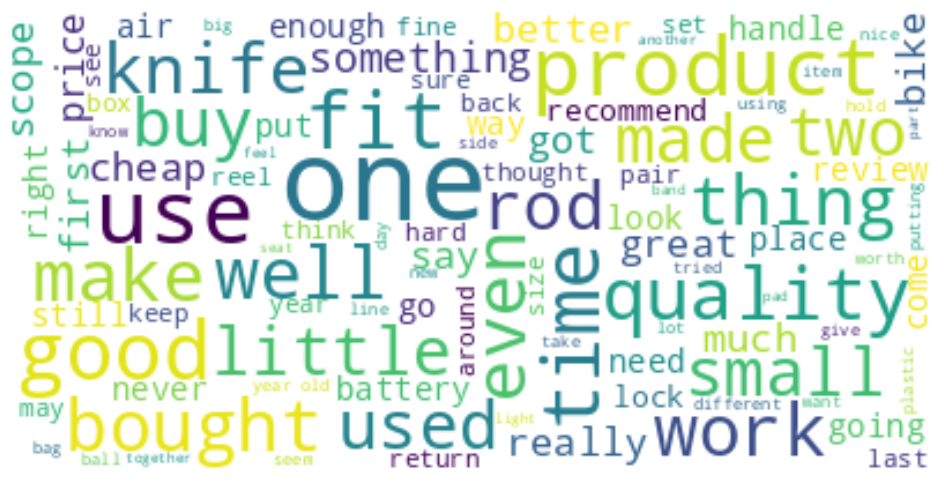

In [166]:
plot_word_cloud(get_words(corpus_negative))

 La palabra "quality" en tamaño considerable, especialmente en un contexto negativo, puede indicar preocupaciones o decepciones con respecto a la calidad del producto. Esto podría ser una señal para los fabricantes de que hay áreas de mejora importantes en el diseño o fabricación de sus productos.